# SELICRD Model

S - susceptable, E - exposed, L - latent, I - infected, C - critical, R - recovered, D - dead

Following:
https://towardsdatascience.com/infectious-disease-modelling-fit-your-model-to-coronavirus-data-2568e672dbc7

![title](model.jpg)

In [1]:
%matplotlib inline
from scipy.integrate import odeint
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import lmfit
from lmfit.lineshapes import gaussian, lorentzian
import matplotlib.dates as mdates
base_dir = 'Data'

First, we define the system of differential equations modelling the flow between compartments

$$\begin{align*}
\dfrac{\delta S}{\delta t} &= - \beta  S \dfrac{I + L}{N}\\
\dfrac{\delta E}{\delta t} &= \beta  S \dfrac{I + L}{N} - \delta  E\\
\dfrac{\delta L}{\delta t} &= \delta  E - \epsilon  p_{L\rightarrow R}  L - \theta  (1 - p_{L\rightarrow R})  L\\
\dfrac{\delta I}{\delta t} &= \theta  (1 - p_{L\rightarrow R})  L - \gamma  (1 - p_{I\rightarrow C})  I  -\lambda  p_{I\rightarrow C}  I\\
\dfrac{\delta C}{\delta t} &= \lambda p_{I\rightarrow C}  I - \tau  \cdot (1 - p_{C\rightarrow D})  \cdot min(beds(t), C) - 
\rho  \cdot p_{C\rightarrow D}  \cdot \min(beds(t), C) - \max(0, C - beds(t))\\
\dfrac{\delta R}{\delta t} &= \gamma  (1 - p_{I\rightarrow R})  I + \tau  (1 - p_{C\rightarrow D})  \cdot \min(beds(t), C) + \epsilon  p_{L\rightarrow R}  L\\
\dfrac{\delta D}{\delta t} &= \rho  \cdot p_{C\rightarrow D}  \cdot min(beds(t), C) + max(0, C-beds(t))
\end{align*}$$

In [2]:
def deriv(y, t, N, beta, delta, epsilon, p_L_to_R, theta, gamma, p_C_to_D, p_I_to_C, lamda, tau, rho, beds):
    S, E, L, I, C, R, D = y
    dSdt = - beta(t) * S * (I + L) / N
    dEdt = beta(t) * S * (I + L) / N - delta * E
    dLdt = delta * E - epsilon * p_L_to_R * L - theta * (1 - p_L_to_R) * L
    dIdt = theta * (1 - p_L_to_R) * L - gamma * (1 - p_I_to_C) * I  - lamda * p_I_to_C * I
    dCdt = lamda * p_I_to_C * I - tau * (1 - p_C_to_D) * min(beds(t), C) - rho * p_C_to_D * min(beds(t), C) \
           - max(0, C - beds(t))
    dRdt = gamma * (1 - p_I_to_C) * I + tau * (1 - p_C_to_D) * min(beds(t), C) + epsilon * p_L_to_R * L
    dDdt = rho * p_C_to_D * min(beds(t), C) + max(0, C-beds(t))
    return dSdt, dEdt, dLdt, dIdt, dCdt, dRdt, dDdt
# def deriv(y, t, N, beta, delta, epsilon, p_L_to_R, theta, gamma, p_C_to_D, p_I_to_C, lamda, tau, rho, beds):
#     S, E, L, I, C, R, D = y
#     dSdt = -beta(t) * S * (I + L) / N
#     dEdt = beta(t) * S * (I + L) / N - delta * E
#     dLdt = delta * E - epsilon * p_L_to_R * L - theta * (1 - p_L_to_R) * L
#     dIdt = theta * (1 - p_L_to_R) * L - gamma * (1 - p_I_to_C) * I  - lamda * p_I_to_C * I
#     dCdt = lamda * p_I_to_C * I - tau * (1 - p_C_to_D) * min(beds(t), C) - rho * p_C_to_D * min(beds(t), C) \
#            - max(0, C - beds(t))
#     dRdt = gamma * (1 - p_I_to_C) * I + tau * (1 - p_C_to_D) * min(beds(t), C) + epsilon * p_L_to_R * L
#     dDdt = rho * p_C_to_D * min(beds(t), C) + max(0, C-beds(t))
#     return dSdt, dEdt, dLdt, dIdt, dCdt, dRdt, dDdt

We can model the declining R0 as a logistical interpolation as "Stay at Home" orders are released and followed. 

In [10]:
def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    if -k*(-t+x0) >= 500: return R_0_end
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end
# def R0_t(t, b, r_s):
#     return (2 / np.pi) * np.arctan(-(t - b) / 20 * r_s) + 1

We can find the numerical solution to the ODEs 

In [4]:
def Model(days, agegroups, beds_per_10k, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s):
    # infection rate comes from current R0
    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma
    # model bed usage in the poplation
    def beds(t):
        beds_0 = beds_per_10k / 10_000 * N
        return beds_0 + s*beds_0*t  # 0.003
    # run model
    N = sum(agegroups)
    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days, days)
    ret = odeint(deriv, y0, t, args=(N, beta, delta, epsilon, p_L_to_R, theta, gamma, p_C_to_D, p_I_to_C, lamda, tau, rho, beds))
    S, E, L, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]
    return t, S, E, L, I, C, R, D, R_0_over_time, beds, p_I_to_C, p_C_to_D
# def Model(days, agegroups, beds_per_100k, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s):
#     def beta(t):
#         return alpha*R0_t(t, b, r_s)
#     N = sum(agegroups)
#     def Beds(t):
#         beds_0 = beds_per_100k / 100_000 * N
#         return beds_0 + s*beds_0*t  # 0.003
#     y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0
#     t = np.linspace(0, days, days)
#     ret = odeint(deriv, y0, t, args=(N, beta, delta, epsilon, p_L_to_R, theta, gamma, p_C_to_D, p_I_to_C, lamda, tau, rho, Beds))
#     S, E, L, I, C, R, D = ret.T
#     R_0_over_time = [beta(i) for i in range(len(t))]
#     return t, S, E, L, I, C, R, D, R_0_over_time, Beds, p_I_to_C, p_C_to_D

In [5]:
def plotter(t, S, E, L, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None: 
        print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")
    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
        # ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, L, 'm', alpha=0.7, linewidth=2, label='Latent')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'c', alpha=0.7, linewidth=2, label='Critical')
        # ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        # ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, L, 'm', alpha=0.7, linewidth=2, label='Latent')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'c', alpha=0.7, linewidth=2, label='Critical')
        # ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()
    ax.title.set_text('SELICRD Model')
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()
    f = plt.figure(figsize=(20,4))
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(delta*E[:i]) if sum(delta*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()
    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()
    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show();

Next, define the hyper-parameter rates of the model

In [6]:
gamma = 1.0 / 17.5 # 9 days from infection to recovery
delta = 1.0 / 2.5  # incubation period of four days
epsilon = 1.0 / 14.0 # two weeks for latent person to recover
theta = 1.0 /2.0 # three days for latent to show symptoms
lamda = 1.0 / 11.0 # five days for infected to be critical
tau = 1.0 / 11.5 # week for critical patients to recover
rho = 1.0 / 7.5 # 7.5 days from critical to death

## Parameter Fitting

In [7]:
params_init_min_max = {"R_0_start": (3.0, 2.0, 10.0), "k": (2.5, 0.01, 10.0), "x0": (57, 20, 100), "R_0_end": (0.9, 0.01, 3.5), "p_L_to_R": (0.6, 0.0, 0.8),
                       "p_I_to_C": (0.05, 0.001, 0.1), "p_C_to_D": (0.5, 0.005, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

# params_init_min_max = {#"R_0_start": (3.0, 2.0, 10.0), "k": (2.5, 0.01, 10.0), "x0": (57, 20, 100), "R_0_end": (0.9, 0.01, 3.5), 
#                        "p_L_to_R": (0.6, 0.0, 0.8),
#                        "alpha": (1, 0.1, 1.25), 
#                        "b": (0, -20, 20), "r_s": (2, 0.1, 10),
#                        "p_I_to_C": (0.05, 0.001, 0.1), "p_C_to_D": (0.5, 0.005, 0.8),
#                        "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}


In [25]:
def run_and_plot(country, outbreak_shift):
    #deaths
    if country == 'China': deaths = pd.read_csv("Data/china_cases_severe_deaths_nhc.csv", header = 0)
    else: deaths = pd.read_csv("Data/world_cases_deaths_EUopendataportal.csv", header = 0)
    deaths = deaths[deaths.country == country]
    data = deaths["deaths_ttl"].values

    # agegroups
    ages = pd.read_csv("Data/agegroups_UNdata.csv")
    agegroups = ages[ages.country_area == country].values[0][2:]
    N = sum(agegroups) #ttl pop

    # beds
    beds = pd.read_csv("Data/beds_UNdata.csv", header=0)
    beds = beds[['country_area','beds']]
    beds = beds.rename(columns={"country_area": "Country", "beds": "ICU_Beds"})
    beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
    beds_per_10k = beds_lookup[country]

    # create outbreak shift
    days = outbreak_shift + len(data)
    if outbreak_shift >= 0:y_data = np.concatenate((np.zeros(outbreak_shift), data))
    else: y_data = data[-outbreak_shift:]
    x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

    # fit model to deaths
    def fitter(x, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s):
        ret = Model(days, agegroups, beds_per_10k, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s)
        return ret[7][x]
#     def fitter(x, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s):
#         ret = Model(days, agegroups, beds_per_10k, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s)
#         return ret[7][x]
    mod = lmfit.Model(fitter)
    for kwarg, (init, mini, maxi) in params_init_min_max.items():
        mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)
    params = mod.make_params()
    fit_method = "leastsq"
    result = mod.fit(y_data, params, method="least_squares", x=x_data)
    print(result.best_values)
    print(np.mean(result.residual **2))
    
    # forward predict
    dates = deaths["date"].values
    first_date = dates[0]
    full_days = len(y_data) + 30
    x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
    predict_range = full_days - len(y_data)
    forecast = Model(full_days, agegroups, beds_per_10k, **result.best_values)
    death_projection = forecast[7]
    fig, ax = plt.subplots()
    ax.plot(x_data, y_data, label="Data")
    ax.plot(x_data, death_projection[:len(y_data)], color="orange", label="Model fit")
    ax.plot(np.arange(x_data[-1],x_data[-1]+predict_range), death_projection[len(y_data):], 
         "--", color="orange", label="Model Prediction")
    label_idx = np.arange(0, len(x_ticks), 15)
    labels = x_ticks[label_idx].strftime("%m/%d")
    location = np.arange(0, len(death_projection))
    label_location = location[label_idx]; ax.set_xticks(label_location)
    ax.set_xticklabels(labels, rotation=45); ax.set_ylabel("Deaths")
    ax.set_title(country) ;ax.legend() ;fig.autofmt_xdate(); plt.show()

    # plot 
    full_days = 500
    x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
    print("Prediction for " + country)
    plotter(*Model(full_days, agegroups, beds_per_10k, **result.best_values), x_ticks=x_ticks);

## United States

{'R_0_start': 6.006716387837009, 'k': 9.988013817580327, 'x0': 92.36915601842426, 'R_0_end': 0.4867376181075001, 'p_L_to_R': 0.006073608002031379, 'p_I_to_C': 0.0012672489619210622, 'p_C_to_D': 0.7996661807616385, 's': 0.003}
217399.11283933968


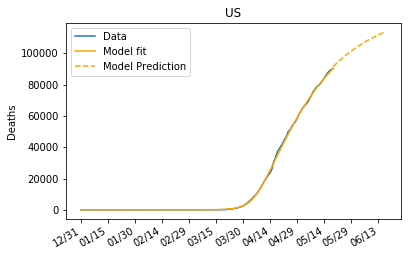

Prediction for US
percentage going to ICU: 0.12672489619210622; percentage dying in ICU: 79.96661807616385


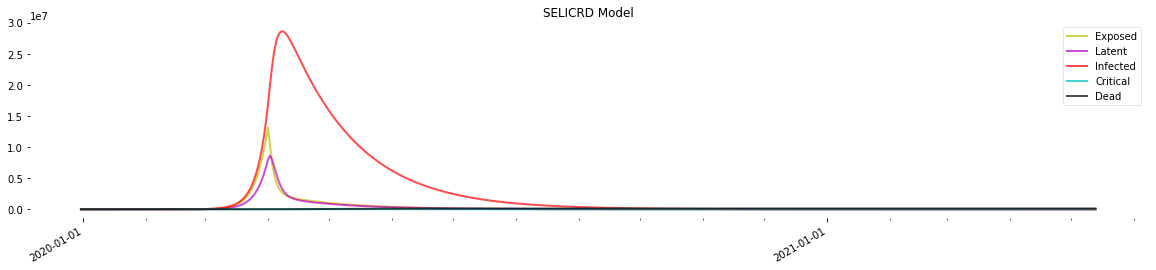

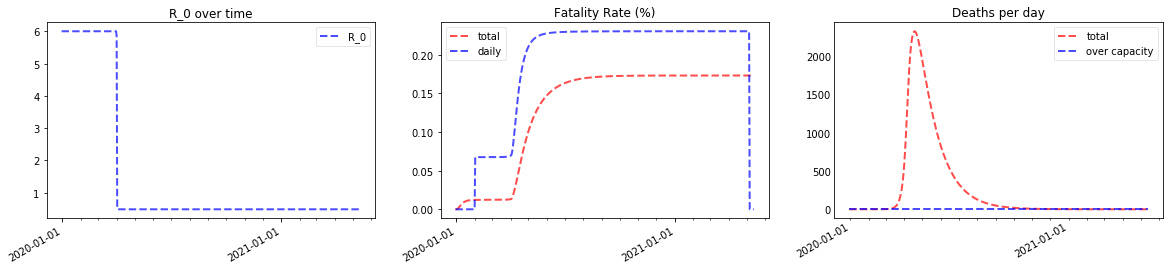

In [11]:
run_and_plot("US", 0)

## China

{'R_0_start': 6.878368196474004, 'k': 9.998978823850628, 'x0': 66.65160672994139, 'R_0_end': 0.5066387145829618, 'p_L_to_R': 7.392638013073829e-22, 'p_I_to_C': 0.0010000000000000002, 'p_C_to_D': 0.7999999999999999, 's': 0.003}
76333.45809443992


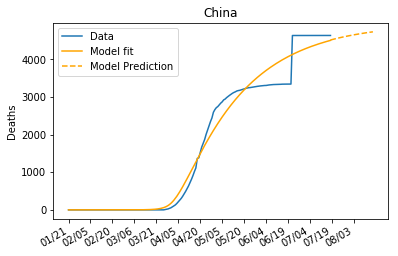

Prediction for China
percentage going to ICU: 0.10000000000000002; percentage dying in ICU: 80.0


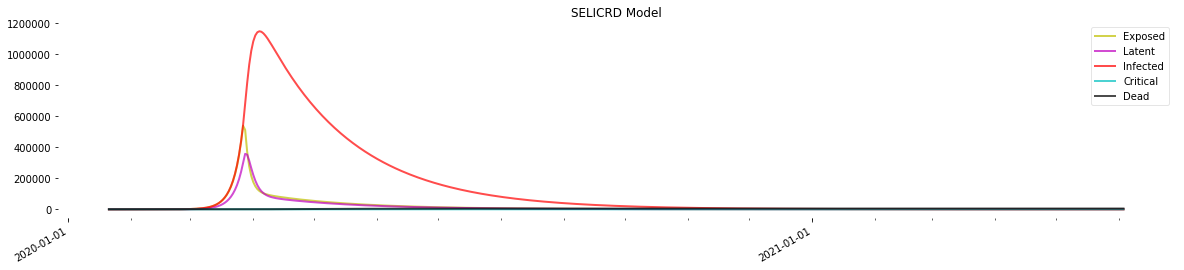

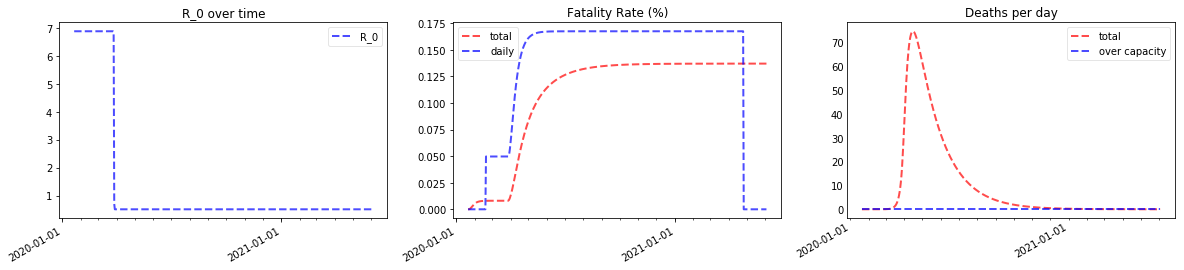

In [26]:
run_and_plot("China", 65)

## Brazil

{'R_0_start': 4.511152558601093, 'k': 7.150287167306732, 'x0': 94.64043957769411, 'R_0_end': 1.9972018365107471, 'p_L_to_R': 0.7999972787189192, 'p_I_to_C': 0.053817419888445045, 'p_C_to_D': 0.23088052689822283, 's': 0.003}
6614.446961608532


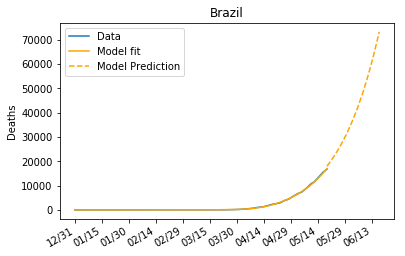

Prediction for Brazil
percentage going to ICU: 5.381741988844505; percentage dying in ICU: 23.088052689822284


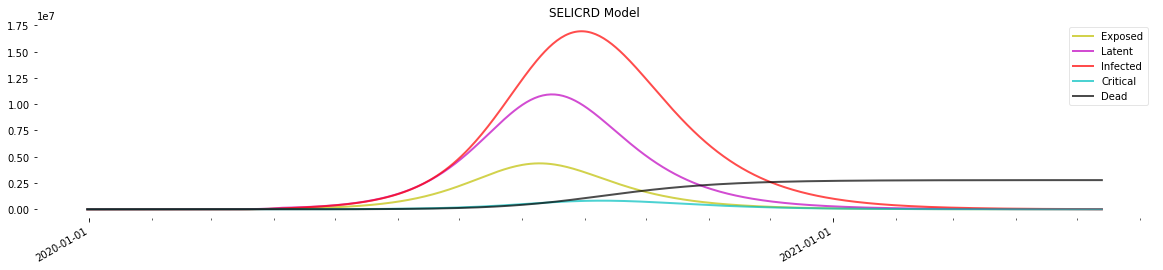

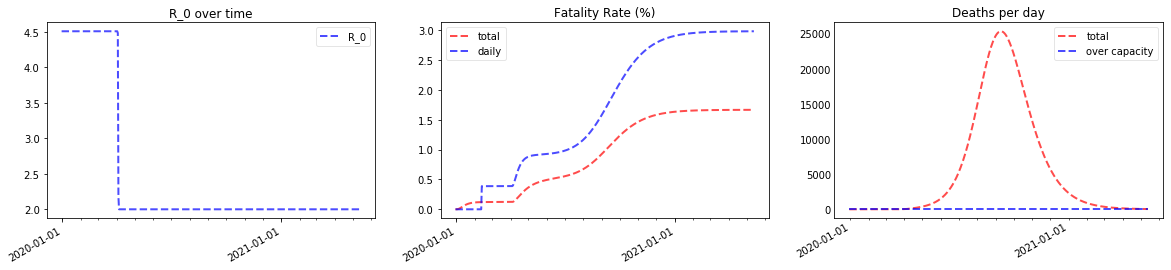

In [14]:
run_and_plot("Brazil", 0)

## India

{'R_0_start': 7.217734198672169, 'k': 0.053412164347007164, 'x0': 75.31537165631391, 'R_0_end': 1.0163124326036708, 'p_L_to_R': 0.7323224348286606, 'p_I_to_C': 0.0010006400842415403, 'p_C_to_D': 0.08885387540059714, 's': 0.003}
482.4084227588381


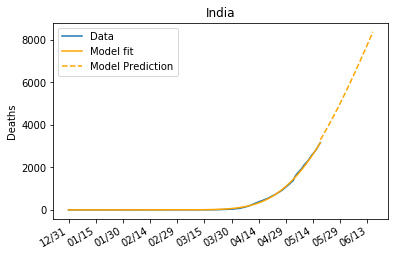

Prediction for India
percentage going to ICU: 0.10006400842415403; percentage dying in ICU: 8.885387540059714


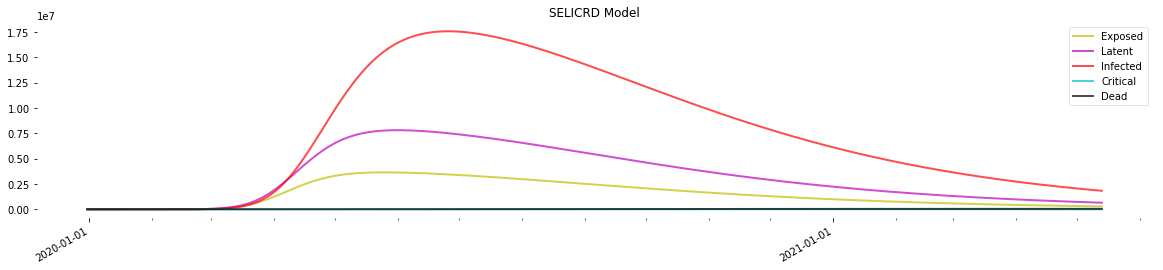

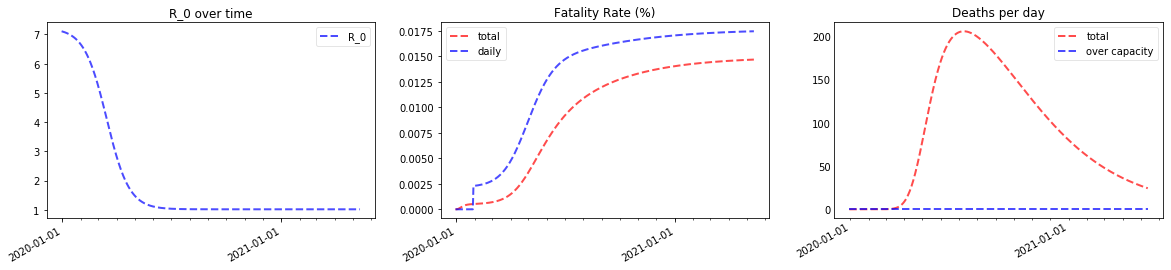

In [15]:
run_and_plot("India", 0)

## Germany

{'R_0_start': 5.838938221773334, 'k': 6.191968524016876, 'x0': 88.78350273060062, 'R_0_end': 0.010147161386091806, 'p_L_to_R': 0.5478152349542227, 'p_I_to_C': 0.0016264510199608788, 'p_C_to_D': 0.3859915760414598, 's': 0.003}
1608.484396151848


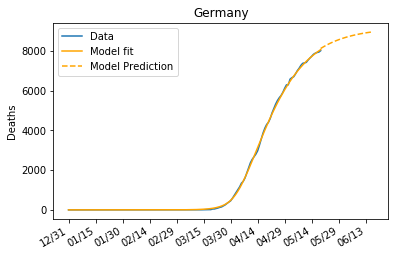

Prediction for Germany
percentage going to ICU: 0.16264510199608787; percentage dying in ICU: 38.59915760414598


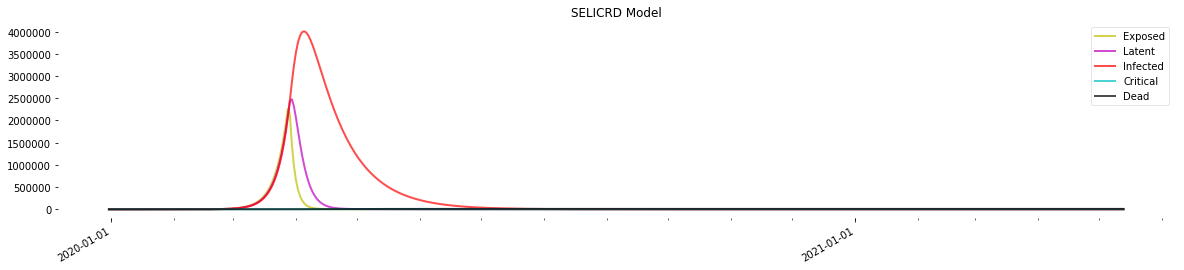

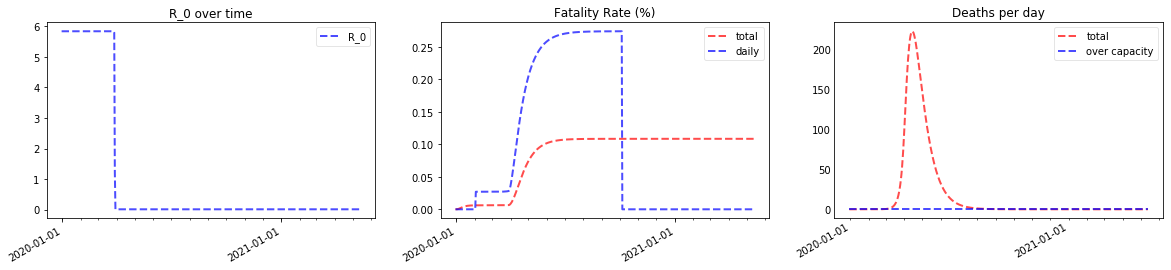

In [16]:
run_and_plot("Germany", 0)

## Italy

{'R_0_start': 6.829325136909823, 'k': 9.99992169211455, 'x0': 73.77969214115235, 'R_0_end': 0.3384425737200983, 'p_L_to_R': 4.712035922592445e-07, 'p_I_to_C': 0.0028376790275548634, 'p_C_to_D': 0.7999999990979901, 's': 0.003}
7702.366336396063


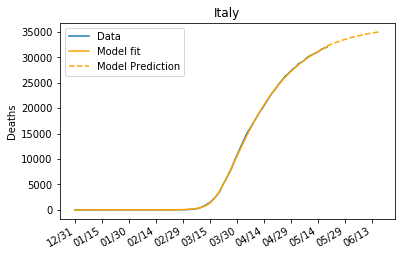

Prediction for Italy
percentage going to ICU: 0.28376790275548636; percentage dying in ICU: 79.99999990979902


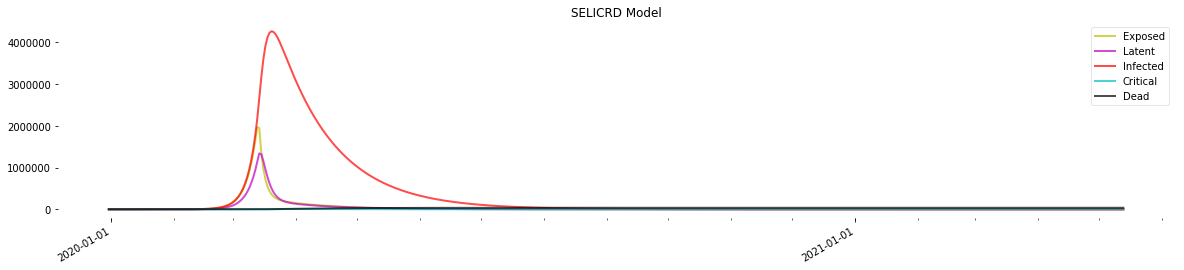

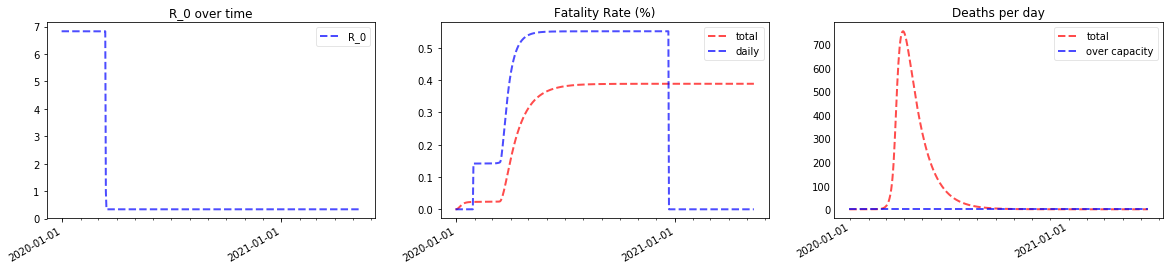

In [17]:
run_and_plot("Italy", 0)

## Spain

{'R_0_start': 6.482812264649804, 'k': 9.751440929350638, 'x0': 81.03273117974288, 'R_0_end': 0.010000000000000002, 'p_L_to_R': 0.0019082682429823533, 'p_I_to_C': 0.0017105071495025703, 'p_C_to_D': 0.7999691298696612, 's': 0.003}
30397.574065477806


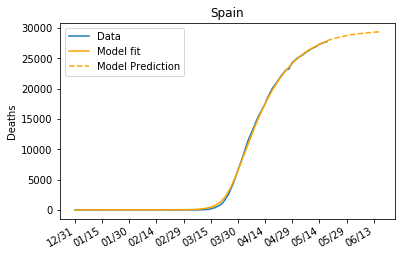

Prediction for Spain
percentage going to ICU: 0.17105071495025703; percentage dying in ICU: 79.99691298696612


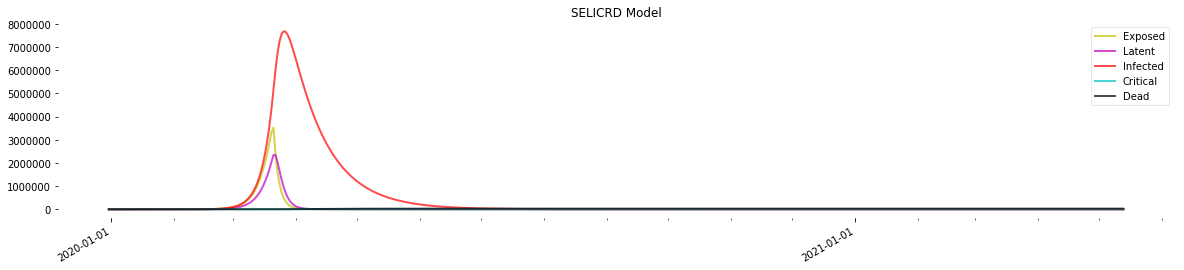

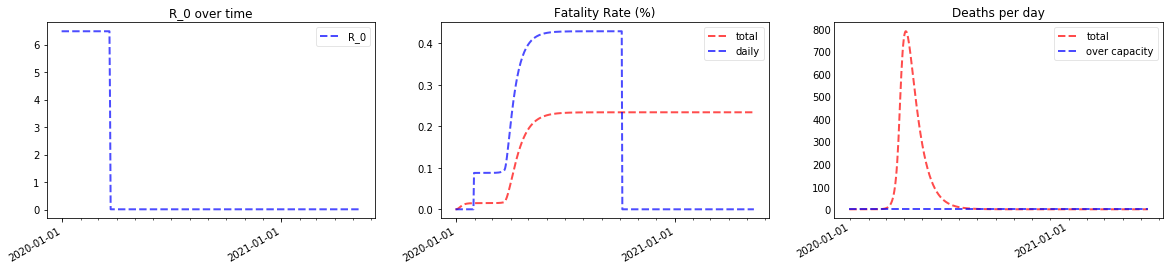

In [18]:
run_and_plot("Spain", 0)

## United Kingdom

{'R_0_start': 5.85406427289708, 'k': 8.065525284331407, 'x0': 90.59970964431159, 'R_0_end': 0.30867710268312437, 'p_L_to_R': 0.001948921650152753, 'p_I_to_C': 0.0013306814257265727, 'p_C_to_D': 0.7971025400985816, 's': 0.003}
15827.934063475483


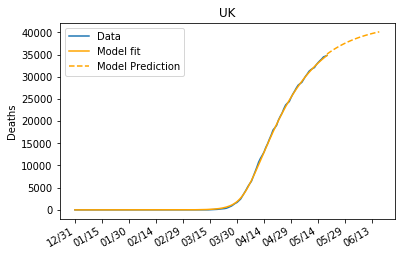

Prediction for UK
percentage going to ICU: 0.13306814257265728; percentage dying in ICU: 79.71025400985816


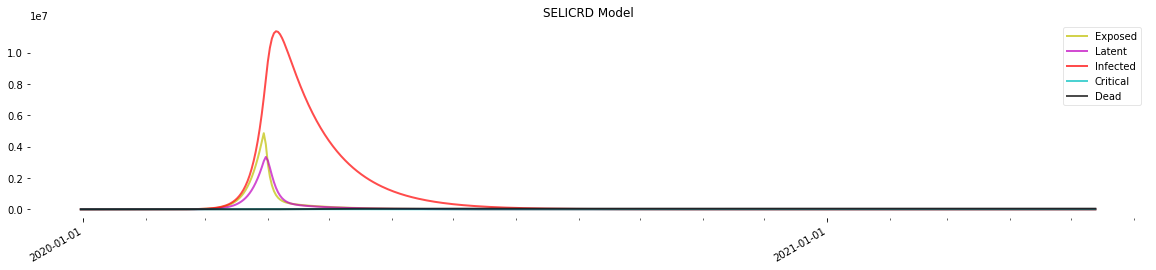

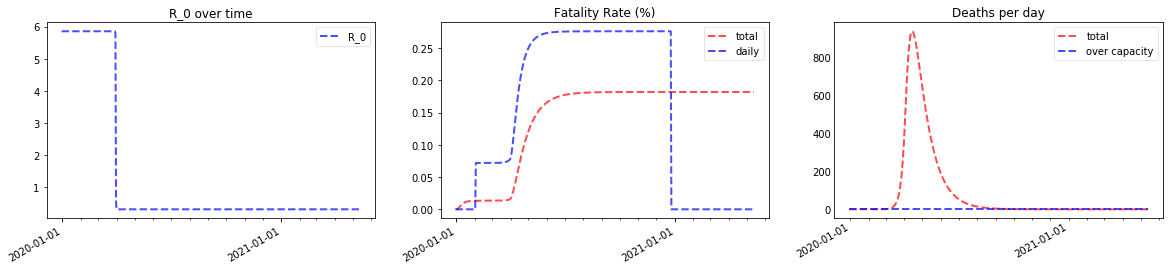

In [19]:
run_and_plot("UK", 0)

## France

{'R_0_start': 6.114831327164179, 'k': 9.847730302612398, 'x0': 86.24857796096299, 'R_0_end': 0.010000000000000002, 'p_L_to_R': 4.1129675148706074e-08, 'p_I_to_C': 0.0014127320476505453, 'p_C_to_D': 0.7999999999999999, 's': 0.003}
142917.4932771115


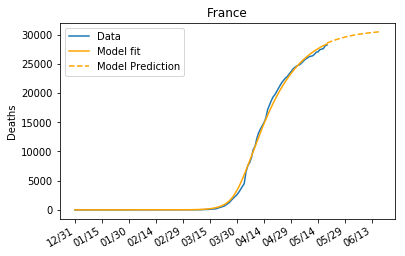

Prediction for France
percentage going to ICU: 0.14127320476505453; percentage dying in ICU: 80.0


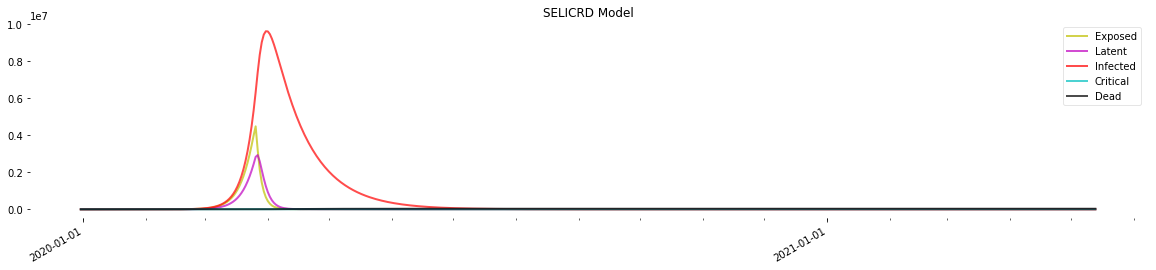

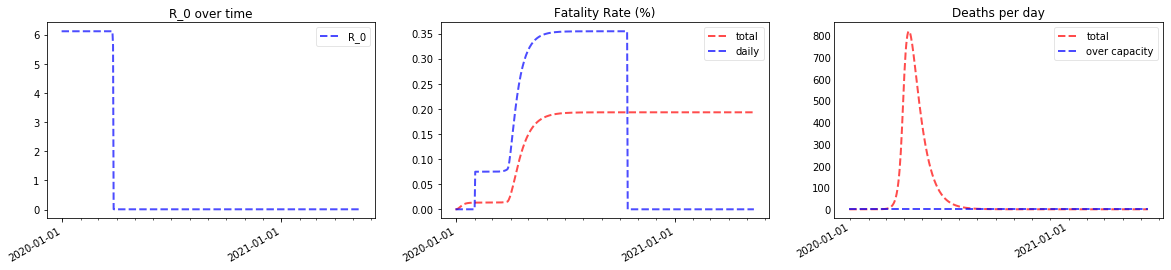

In [20]:
run_and_plot("France", 0)

## Canada

{'R_0_start': 7.8319211649248155, 'k': 0.011090610493785876, 'x0': 90.33534077597938, 'R_0_end': 3.4127335653723025, 'p_L_to_R': 0.7999986758650824, 'p_I_to_C': 0.008191038947835528, 'p_C_to_D': 0.018430131005562136, 's': 0.003}
511.44456739183505


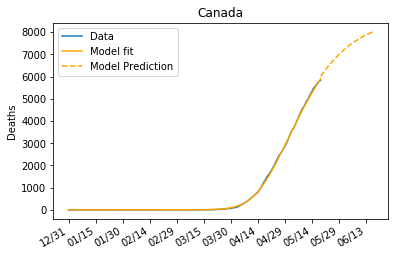

Prediction for Canada
percentage going to ICU: 0.8191038947835528; percentage dying in ICU: 1.8430131005562136


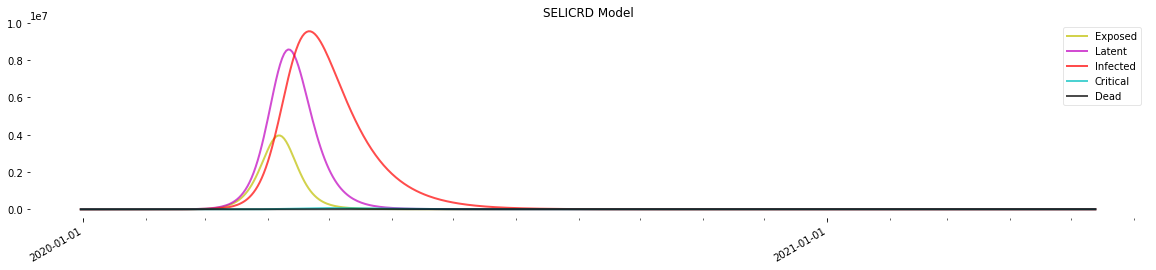

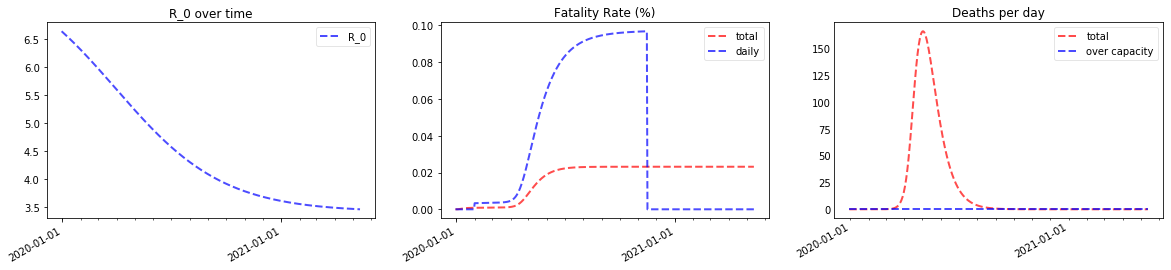

In [21]:
run_and_plot("Canada", 0)

## Netherlands

{'R_0_start': 5.833372548912068, 'k': 8.551764148322652, 'x0': 84.98190081124534, 'R_0_end': 0.010028653339065679, 'p_L_to_R': 0.07227663535560008, 'p_I_to_C': 0.005680791872399328, 'p_C_to_D': 0.08897975753161966, 's': 0.003}
979.6152159397334


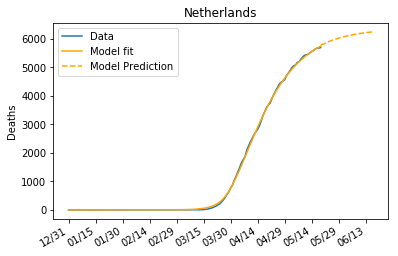

Prediction for Netherlands
percentage going to ICU: 0.5680791872399328; percentage dying in ICU: 8.897975753161965


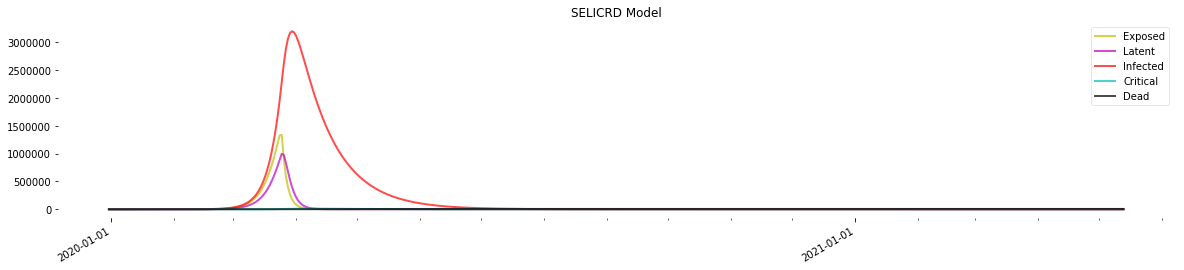

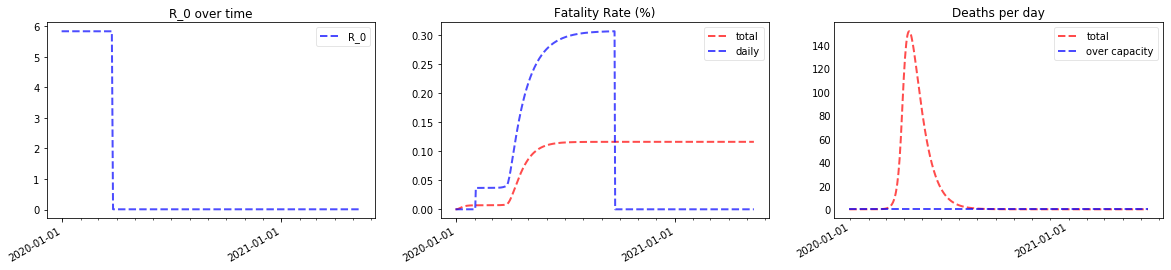

In [13]:
run_and_plot("Netherlands", 0)